In [1]:
#German
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.model_selection import train_test_split

from csse import CSSE
from prepare_dataset import *

import pickle

import numpy as np
import pandas as pd
import graphviz
import lingam
from lingam.utils import print_causal_directions, print_dagc, make_dot

from tqdm import tqdm
import random as rnd

from IPython.display import display

import warnings

warnings.filterwarnings('ignore')

In [69]:
x0 = np.random.uniform(size=1000) * 100
x1 = 2*x0 + np.random.uniform(size=1000)  * 100
x2 = -1*x0 + 3*x1 + np.random.uniform(size=1000)  * 100
x3 = np.random.uniform(size=1000)  * 100
X = pd.DataFrame(np.array([x0, x1, x2, x3]).T ,columns=['Velocidade', 'Consumo', 'Tempo', 'Preço'])
X.head()

,Velocidade,Consumo,Tempo,Preço
0,96.063899,206.707401,577.636288,93.582474
1,62.523236,136.342293,438.278006,77.584445
2,59.075000,181.589303,537.931415,24.500504
3,76.742196,196.359912,603.787939,3.264560
4,12.171328,41.340419,191.185824,79.090273


In [80]:
print(X)

     Velocidade     Consumo       Tempo      Preço
0     96.063899  206.707401  577.636288  93.582474
1     62.523236  136.342293  438.278006  77.584445
2     59.075000  181.589303  537.931415  24.500504
3     76.742196  196.359912  603.787939   3.264560
4     12.171328   41.340419  191.185824  79.090273
..          ...         ...         ...        ...
995   96.248453  205.977632  606.740943  70.625762
996   54.990561  174.164020  467.965883  56.522952
997   51.228794  153.188867  429.793008  63.281857
998   89.147712  271.155853  731.055999  94.764981
999   16.961596  132.226888  416.611096  62.541654

[1000 rows x 4 columns]


In [70]:
model_lingam = lingam.DirectLiNGAM()

result_lingam_bt = model_lingam.bootstrap(X, n_sampling=100)

causal_effects = result_lingam_bt.get_total_causal_effects(min_causal_effect=0.01)

df_causal_effects = pd.DataFrame(causal_effects)
labels = [f'{i}' for i in X.columns]

df_causal_effects['from'] = df_causal_effects['from'].apply(lambda x : labels[x])
df_causal_effects['to'] = df_causal_effects['to'].apply(lambda x : labels[x])

causal_order = [labels[x] for x in model_lingam.causal_order_]

In [71]:
causal_order

['Velocidade', 'Consumo', 'Preço', 'Tempo']

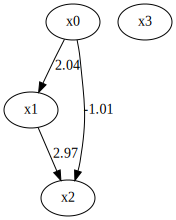

In [72]:
make_dot(model_lingam.adjacency_matrix_)


In [73]:
df_causal_effects

,from,to,effect,probability
0,Velocidade,Consumo,2.060413,1.00
1,Velocidade,Tempo,5.136606,1.00
2,Consumo,Tempo,2.980805,1.00
3,Preço,Tempo,0.264205,0.07
4,Preço,Consumo,0.090951,0.06
5,Velocidade,Preço,-0.101854,0.02


In [95]:
model = lingam.DirectLiNGAM()
model.fit(X)

In [96]:
model.causal_order_

[0, 1, 3, 2]

In [97]:
model.adjacency_matrix_

array([[ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 2.052239  ,  0.        ,  0.        ,  0.        ],
       [-1.00573934,  2.98210627,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ]])

In [98]:
matrix = model.adjacency_matrix_
from_list = []
to_list = []
effect_list = []

# Iteração sobre a matriz para extrair os valores e suas posições
for i in range(len(matrix)):
    for j in range(len(matrix[i])):
        if matrix[i][j] != 0:
            from_list.append(j)
            to_list.append(i)
            effect_list.append(matrix[i][j])

# Criando o DataFrame
df = pd.DataFrame({'from': from_list, 'to': to_list, 'effect': effect_list})
labels = [f'{i}' for i in X.columns]
df['from'] = df['from'].apply(lambda x : labels[x])
df['to'] = df['to'].apply(lambda x : labels[x])
df

,from,to,effect
0,Velocidade,Consumo,2.052239
1,Velocidade,Tempo,-1.005739
2,Consumo,Tempo,2.982106


In [99]:
causal_order

['Velocidade', 'Consumo', 'Preço', 'Tempo']

In [85]:
print(df)

         from       to    effect
0  Velocidade  Consumo  2.052239
1  Velocidade    Tempo -1.005739
2     Consumo    Tempo  2.982106


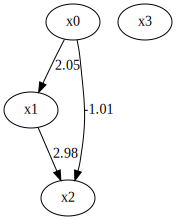

In [86]:
make_dot(model.adjacency_matrix_)


In [88]:
p_values = model.get_error_independence_p_values(X)
p_values

array([[0.        , 0.74085017, 0.98446081, 0.3819405 ],
       [0.74085017, 0.        , 0.41600505, 0.00395773],
       [0.98446081, 0.41600505, 0.        , 0.77543897],
       [0.3819405 , 0.00395773, 0.77543897, 0.        ]])

In [90]:
# Criando um DataFrame apenas com os valores da parte superior da diagonal principal
valores = []
for i in range(len(p_values)):
    for j in range(i + 1, len(p_values)):
        valores.append(p_values[i, j])

df_e = pd.DataFrame(valores, columns=['Valores'])
print(df_e)


    Valores
0  0.740850
1  0.984461
2  0.381940
3  0.416005
4  0.003958
5  0.775439


In [91]:
matrix = model.get_error_independence_p_values(X)
from_list = []
to_list = []
effect_list = []

# Iteração sobre a matriz para extrair os valores e suas posições
for i in range(len(matrix)):
    for j in range(i + 1, len(matrix[i])):
        if matrix[i][j] != 0:
            from_list.append(j)
            to_list.append(i)
            effect_list.append(matrix[i][j])

# Criando o DataFrame
df_e = pd.DataFrame({'from': from_list, 'to': to_list, 'effect': effect_list})
labels = [f'{i}' for i in X.columns]
df_e['from'] = df_e['from'].apply(lambda x : labels[x])
df_e['to'] = df_e['to'].apply(lambda x : labels[x])
df_e

,from,to,effect
0,Consumo,Velocidade,0.740850
1,Tempo,Velocidade,0.984461
2,Preço,Velocidade,0.381940
3,Tempo,Consumo,0.416005
4,Preço,Consumo,0.003958
5,Preço,Tempo,0.775439


In [93]:
print(df_e)

      from          to    effect
0  Consumo  Velocidade  0.740850
1    Tempo  Velocidade  0.984461
2    Preço  Velocidade  0.381940
3    Tempo     Consumo  0.416005
4    Preço     Consumo  0.003958
5    Preço       Tempo  0.775439


In [92]:
matrix

array([[0.        , 0.74085017, 0.98446081, 0.3819405 ],
       [0.74085017, 0.        , 0.41600505, 0.00395773],
       [0.98446081, 0.41600505, 0.        , 0.77543897],
       [0.3819405 , 0.00395773, 0.77543897, 0.        ]])